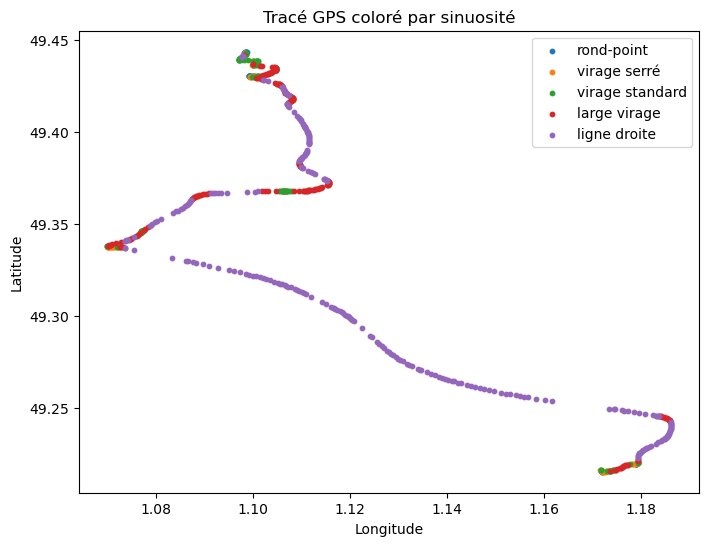

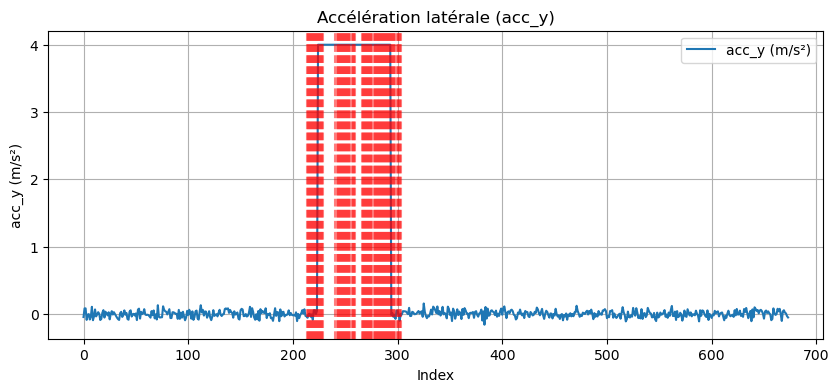

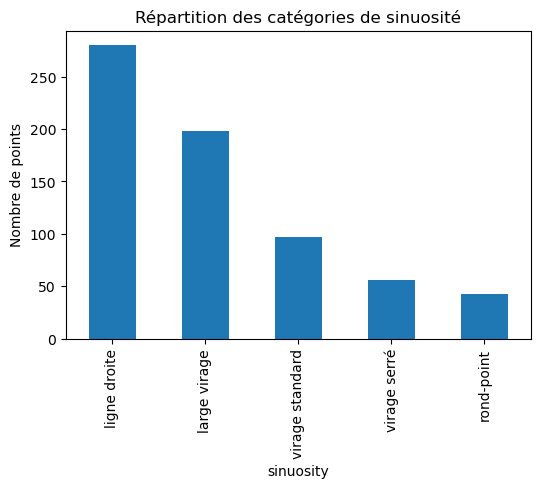

In [4]:
# RoadSimulator3 - Visualisation Sinuosité & Virages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('/Users/sebastien.edet/projects/RoadSimulator3/'))
from core.sinuosity import apply_sinuosity_to_df
from core.osrm_utils import get_route_from_coords
from check.check_realism import detect_turns
from simulator import events

# -- Paramètres --
start = (49.4431, 1.0993)  # Rouen
end = (49.2164, 1.1711)    # Louviers

# -- Récupération d'un itinéraire OSRM --
geometry, route = get_route_from_coords([start, end])
df = pd.DataFrame(route, columns=['lat', 'lon'])

# -- Ajout colonnes simulées --
df['speed'] = 30.0
df['acc_x'] = 0.0
df['acc_y'] = np.random.normal(0, 0.05, len(df))
df['acc_z'] = events.G
df['event'] = np.nan

# -- Injection d'un virage artificiel --
virage_idx = len(df) // 3
for i in range(virage_idx, virage_idx + 70):
    if i < len(df):
        df.at[i, 'acc_y'] = 4.0  # Forte accélération latérale

# -- Calcul sinuosité --
df = apply_sinuosity_to_df(df, geometry_coords=geometry['coordinates'], window=15)

# -- Détection des virages --
turn_indices = detect_turns(df, acc_y_threshold=0.5, heading_threshold=15)

# --- VISUALISATION ---

## 1. Tracé GPS avec sinuosité
plt.figure(figsize=(8, 6))
categories = df['sinuosity'].unique()
colors = plt.cm.tab10.colors

for idx, category in enumerate(categories):
    subset = df[df['sinuosity'] == category]
    plt.scatter(subset['lon'], subset['lat'], label=category, color=colors[idx % len(colors)], s=10)

plt.title('Tracé GPS coloré par sinuosité')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

## 2. Accélération latérale acc_y
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['acc_y'], label='acc_y (m/s²)')
plt.title('Accélération latérale (acc_y)')
plt.xlabel('Index')
plt.ylabel('acc_y (m/s²)')
plt.grid()

# Marquer les virages détectés
for idx in turn_indices:
    plt.axvline(idx, color='red', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

## 3. Histogramme sinuosité
plt.figure(figsize=(6, 4))
df['sinuosity'].value_counts().plot(kind='bar')
plt.title('Répartition des catégories de sinuosité')
plt.ylabel('Nombre de points')
plt.show()
